In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime as dt
from sklearn.linear_model import LinearRegression

# Aux

In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def mem_usage(df):
    return df.memory_usage().sum()/1024**2

In [4]:
def read_file(filename):
    t0 = time()
    df = pd.read_csv(filename)
    load_time = time()-t0
    print(f'{filename} read in {load_time:.1f} s')
    # reduce mem usage
    df = reduce_mem_usage(df)
    return df

In [212]:
def split_timestamp(df):
    # dataframe must have a column called timestamp
    df["hour"] = df["timestamp"].dt.hour.astype('int8')
    df["day"] = df["timestamp"].dt.day.astype('int8')
    df["year"] = df["timestamp"].dt.year.astype('int32')
    df["weeknumber"] = df["timestamp"].dt.week.astype('int8')
    df["weekday"] = df["timestamp"].dt.weekday.astype('int8')
    df["month"] = df["timestamp"].dt.month.astype('int8')
    return df

# Read data files

In [5]:
train_df = read_file('train.csv')
# convert into timestamp object
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'],format='%Y-%m-%d %H:%M:%S')
# split timestamp
train_df = split_timestamp(train_df)

train.csv read in 10.9 s
Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [6]:
train_df['log_meter_reading'] = np.log(1+train_df['meter_reading'])


In [7]:
# split date values
train_df["hour"] = train_df["timestamp"].dt.hour.astype('int8')
train_df["day"] = train_df["timestamp"].dt.day.astype('int8')
train_df["year"] = train_df["timestamp"].dt.year.astype('int32')
train_df["weeknumber"] = train_df["timestamp"].dt.week.astype('int8')
train_df["weekday"] = train_df["timestamp"].dt.weekday.astype('int8')
train_df["month"] = train_df["timestamp"].dt.month.astype('int8')

In [8]:
mem_usage(train_df)

539.8282318115234

In [9]:
train_df.head()

,building_id,meter,timestamp,meter_reading,log_meter_reading,hour,day,year,weeknumber,weekday,month
0,0,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1
1,1,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1
2,2,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1
3,3,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1
4,4,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1


In [10]:
train_df.tail()

,building_id,meter,timestamp,meter_reading,log_meter_reading,hour,day,year,weeknumber,weekday,month
20216095,1444,0,2016-12-31 23:00:00,8.750000,2.277267,23,31,2016,52,5,12
20216096,1445,0,2016-12-31 23:00:00,4.825000,1.762159,23,31,2016,52,5,12
20216097,1446,0,2016-12-31 23:00:00,0.000000,0.000000,23,31,2016,52,5,12
20216098,1447,0,2016-12-31 23:00:00,159.574997,5.078761,23,31,2016,52,5,12
20216099,1448,0,2016-12-31 23:00:00,2.850000,1.348073,23,31,2016,52,5,12


In [51]:
xx = train_df.groupby('building_id')['meter'].nunique()

In [52]:
sum(xx==4)

13

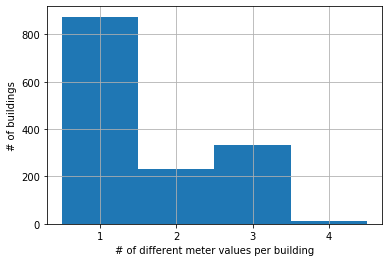

In [17]:
train_df.groupby('building_id')['meter'].nunique().hist(bins= np.arange(0.5,5.5,1));
plt.xticks(np.arange(1,5));
plt.ylabel('# of buildings')
plt.xlabel('# of different meter values per building');

In [47]:
max_data_points = 366*24
bins = np.concatenate( ( np.arange(0,9000,1000), np.array([max_data_points-.5]) ) )
max_bin = np.array([max_data_points-.5, max_data_points+50])
bins

array([   0. , 1000. , 2000. , 3000. , 4000. , 5000. , 6000. , 7000. ,
       8000. , 8783.5])

In [33]:
building_meter_datapoints = train_df.groupby(['building_id','meter'])['meter_reading'].count().to_frame()
building_meter_datapoints.head()

,,meter_reading
building_id,meter,
0,0,8784
1,0,8784
2,0,8784
3,0,8784
4,0,8784


In [46]:
building_meter_datapoints.shape

(2380, 1)

In [27]:
sum(building_meter_datapoints==max_data_points)

720

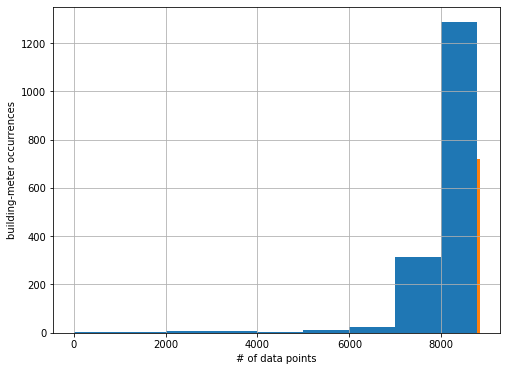

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(building_meter_datapoints.meter_reading, bins=bins,histtype='bar')
ax.hist(building_meter_datapoints.meter_reading, bins=max_bin)
plt.grid();
#plt.yscale('log');
plt.xlabel('# of data points');
plt.ylabel('building-meter occurrences');

In [55]:
building_meter_datapoints.loc[building_meter_datapoints.idxmin()]

,,meter_reading
building_id,meter,
403,0,479


In [67]:
(train_df['building_id']==403) & (train_df['meter']==0)

0           False
1           False
2           False
3           False
4           False
            ...  
20216095    False
20216096    False
20216097    False
20216098    False
20216099    False
Length: 20216100, dtype: bool

In [68]:
b_403_0 = train_df[(train_df['building_id']==403) & (train_df['meter']==0)]


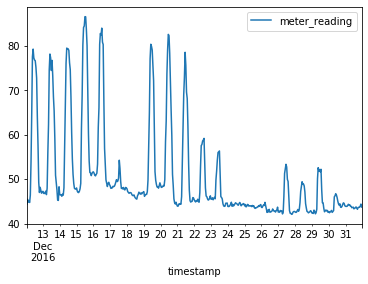

In [69]:
b_403_0.plot(x='timestamp',y='meter_reading')

In [71]:
b_403_0.head()

,building_id,meter,timestamp,meter_reading,log_meter_reading,hour,day,year,weeknumber,weekday,month
19085659,403,0,2016-12-12 01:00:00,44.349998,3.814410,1,12,2016,50,0,12
19088023,403,0,2016-12-12 02:00:00,45.450001,3.838377,2,12,2016,50,0,12
19090387,403,0,2016-12-12 03:00:00,44.820000,3.824721,3,12,2016,50,0,12
19092751,403,0,2016-12-12 04:00:00,45.110001,3.831030,4,12,2016,50,0,12
19095115,403,0,2016-12-12 05:00:00,44.730000,3.822755,5,12,2016,50,0,12


In [11]:
# building table
building_df = read_file('building_metadata.csv')

building_metadata.csv read in 0.2 s
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [12]:
building_df['log_square_feet'] = np.log(building_df['square_feet'])

In [75]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,log_square_feet
0,0,0,Education,7432,2008.0,NaN,8.913550
1,0,1,Education,2720,2004.0,NaN,7.908387
2,0,2,Education,5376,1991.0,NaN,8.589700
3,0,3,Education,23685,2002.0,NaN,10.072597
4,0,4,Education,116607,1975.0,NaN,11.666565


In [13]:
# weather(train) table
weather_train_table = read_file('weather_train.csv')
weather_train_table['timestamp'] = pd.to_datetime(weather_train_table['timestamp'],format='%Y-%m-%d %H:%M:%S')

weather_train.csv read in 0.3 s
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [12]:
weather_train_table.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [14]:
trainbuilding_df = train_df.join(building_df, on='building_id', rsuffix = 'r')
trainbuilding_df.drop(columns=['year_built','floor_count','building_idr'],inplace=True)
trainbuilding_df.head()

,building_id,meter,timestamp,meter_reading,log_meter_reading,hour,day,year,weeknumber,weekday,month,site_id,primary_use,square_feet,log_square_feet
0,0,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1,0,Education,7432,8.913550
1,1,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1,0,Education,2720,7.908387
2,2,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1,0,Education,5376,8.589700
3,3,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1,0,Education,23685,10.072597
4,4,0,2016-01-01,0.0,0.0,0,1,2016,53,4,1,0,Education,116607,11.666565


In [78]:
trainbuilding_df.shape

(20216100, 15)

In [79]:
trainbuilding_df[['log_meter_reading','log_square_feet']].corr()

,log_meter_reading,log_square_feet
log_meter_reading,1.000000,0.444647
log_square_feet,0.444647,1.000000


In [80]:
trainbuilding_df[['meter_reading','square_feet']].corr()

,meter_reading,square_feet
meter_reading,1.000000,0.024308
square_feet,0.024308,1.000000


In [15]:
tbw = pd.merge(trainbuilding_df, weather_train_table,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

In [16]:
tbw.head()

,building_id,meter,timestamp,meter_reading,log_meter_reading,hour,day,year,weeknumber,weekday,...,primary_use,square_feet,log_square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,7432,8.913550,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,2720,7.908387,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,5376,8.589700,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,23685,10.072597,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,116607,11.666565,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [19]:
use_meter_count= tbw.groupby(['primary_use','meter'])['meter_reading'].count().to_frame()

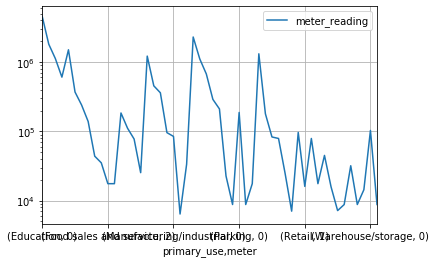

In [21]:
use_meter_count.plot()
plt.yscale('log')
plt.grid();

In [192]:
tbw[['air_temperature','log_meter_reading']].corr()

,air_temperature,log_meter_reading
air_temperature,1.000000,-0.004704
log_meter_reading,-0.004704,1.000000


In [15]:
tbw_edu0= tbw[tbw['primary_use']=='Education']
tbw_edu0 = tbw_edu0[tbw_edu0['meter']==0]
tbw_edu0.head()


,building_id,meter,timestamp,meter_reading,log_meter_reading,hour,day,year,weeknumber,weekday,...,primary_use,square_feet,log_square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,7432,8.913550,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,2720,7.908387,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,5376,8.589700,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,23685,10.072597,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0.0,0,1,2016,53,4,...,Education,116607,11.666565,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [361]:
tb_edu0.shape

(4578935, 21)

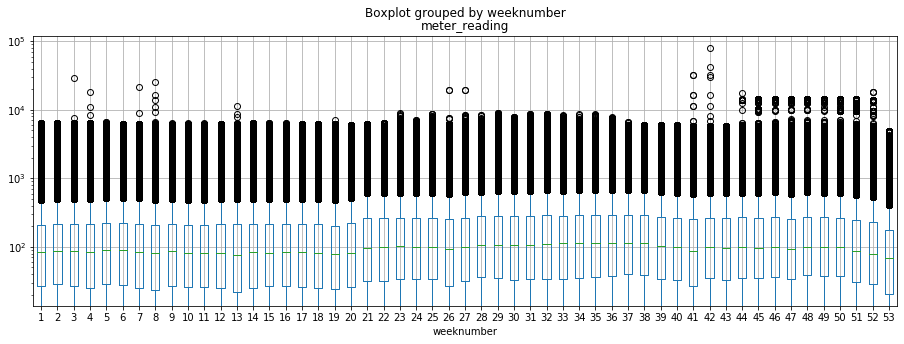

In [66]:
fig =plt.figure(figsize=(15,5))
ax = fig.add_subplot()
#tb_edu0.groupby('weeknumber')['meter_reading'].min().plot(ax = ax);
tbw_edu0.boxplot(column='meter_reading', by='weeknumber',ax=ax)
#tb_edu0.groupby('weeknumber')['meter_reading'].max().plot(ax = ax);
plt.yscale('log')
#plt.ylim(0,10000)

In [168]:
mm = tbw_edu0[tbw_edu0['weeknumber']==30]
build_ave = mm.groupby('building_id')[['meter_reading','air_temperature']].mean()
build_ave.head()

,meter_reading,air_temperature
building_id,,
0,294.638458,28.6875
1,134.672409,28.6875
2,27.780201,28.6875
3,433.427765,28.6875
4,1657.057129,28.6875


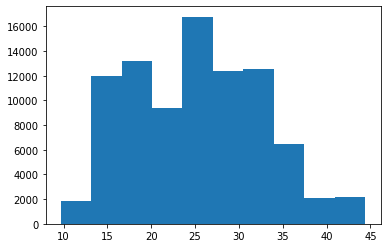

In [183]:
plt.hist(mm.air_temperature);

(1, 100000)

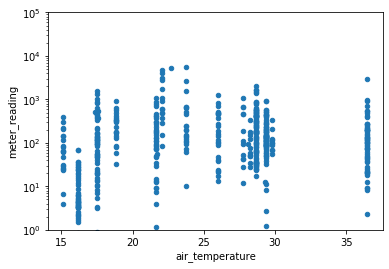

In [169]:
build_ave.plot(x='air_temperature',y='meter_reading',kind='scatter');
plt.yscale('log')
plt.ylim(1,100000)

In [170]:
build_ave = pd.DataFrame(build_ave).join(building_df, on='building_id', rsuffix='r')
build_ave.head()

,meter_reading,air_temperature,site_id,building_id,primary_use,square_feet,year_built,floor_count
building_id,,,,,,,,
0,294.638458,28.6875,0,0,Education,7432,2008.0,NaN
1,134.672409,28.6875,0,1,Education,2720,2004.0,NaN
2,27.780201,28.6875,0,2,Education,5376,1991.0,NaN
3,433.427765,28.6875,0,3,Education,23685,2002.0,NaN
4,1657.057129,28.6875,0,4,Education,116607,1975.0,NaN


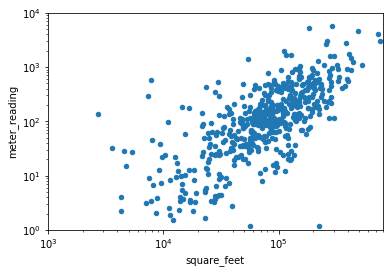

In [171]:
build_ave.plot(x='square_feet',y='meter_reading',kind='scatter')
plt.ylim(1,10000)
plt.xlim(1000,800000)
plt.yscale('log')
plt.xscale('log')

In [172]:
build_ave[['meter_reading','square_feet']].corr()

,meter_reading,square_feet
meter_reading,1.000000,0.599923
square_feet,0.599923,1.000000


In [163]:
# reg with square feet only
#lr = LinearRegression()
X = build_ave['square_feet']
y = build_ave['meter_reading']
f1= np.polyfit(X,y,1)


In [164]:
f1

array([ 4.05598512e-03, -1.57823673e+02])

In [165]:
np.corrcoef(X,y)

array([[1.        , 0.61273966],
       [0.61273966, 1.        ]])

In [153]:
X = np.array( [np.log(build_ave['square_feet']), build_ave['air_temperature']] )
X = np.transpose(X)
X.shape

(532, 2)

In [173]:

lr = LinearRegression()
X = np.array( [np.log(build_ave['square_feet']), build_ave['air_temperature']] )
X = np.transpose(X)

y = np.log(build_ave['meter_reading']+1)
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [174]:
lr.score(X,y)

0.5000417453176721

In [156]:
pred = lr.predict(X)

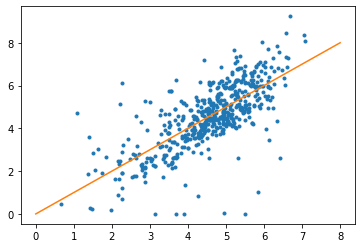

In [161]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pred,y,marker='.',linewidth=0)
ax.plot([0 ,8],[0,8])
#plt.xscale('log')
#plt.yscale('log')

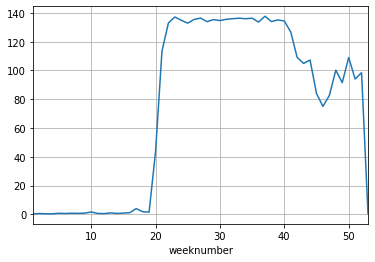

In [55]:
bid = 1
bb = tb_edu0[tb_edu0['building_id']==bid];
bb.groupby('weeknumber')['meter_reading'].mean().plot();
plt.grid()

# Regressions

In [26]:
use_list = np.unique(building_df['primary_use'])
meter_list = np.arange(0,4)
features_list=['weeknumber','weekday','hour','log_square_feet','air_temperature']

In [30]:
use_list[0]

'Education'

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

out = []
dtrs = []
for use in use_list:
    for meter in meter_list:
        print('---------------------')
        print('Extracting data for: ', use, meter)
        print('')
        # extract by primary use and meter value
        sub_df = tbw[(tbw['primary_use']== use) & (tbw['meter']==meter)]
        
        X=sub_df[features_list]
        y=sub_df['log_meter_reading']
        
        #eliminate points with no temperature
        cond = ~X['air_temperature'].isnull() 
        print(sum(cond),'datapoints')
        X = X[cond]
        y = y[cond]
        
        if len(y)==0:
            continue        
        
        print('Train-test split...')
        # train-test split
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.75, random_state=42)
        print('X_train shape: ', X_train.shape)
        print('X_test shape: ', X_test.shape)

        # fit
        print('Fitting model...')
        t0 = time()
        dtr = DecisionTreeRegressor(min_samples_leaf = 1, min_samples_split=2)
        dtr.fit(X_train,y_train)
        print('Fit in {:.1f}s'.format(time()-t0) )
        
        print('Validating...')
        # predict
        pred = dtr.predict(X_test)
        
        # validate model
        R2 = r2_score(y_test,pred)
        mse = mean_squared_error(y_test,pred)
        print('R2 :', R2)
        print('MSE :', mse)
        
        # attach results
        out.append([use, meter, len(y), R2, mse])
        dtrs.append(dtr)
        print('Done')
        print('')
        
        

---------------------
Extracting data for:  Education 0

4577522 datapoints
Train-test split...
X_train shape:  (3433141, 5)
X_test shape:  (1144381, 5)
Fitting model...
Fit in 21.8s
Validating...
R2 : 0.973198610428083
MSE : 0.08369786091096103
Done

---------------------
Extracting data for:  Education 1

1812418 datapoints
Train-test split...
X_train shape:  (1359313, 5)
X_test shape:  (453105, 5)
Fitting model...
Fit in 7.5s
Validating...
R2 : 0.9010963627059718
MSE : 0.6683176555659004
Done

---------------------
Extracting data for:  Education 2

1125729 datapoints
Train-test split...
X_train shape:  (844296, 5)
X_test shape:  (281433, 5)
Fitting model...
Fit in 4.5s
Validating...
R2 : 0.8295194146994276
MSE : 1.2436525095256816
Done

---------------------
Extracting data for:  Education 3

606440 datapoints
Train-test split...
X_train shape:  (454830, 5)
X_test shape:  (151610, 5)
Fitting model...
Fit in 1.9s
Validating...
R2 : 0.8449321368327856
MSE : 1.0107098030554085
Done

-

17564 datapoints
Train-test split...
X_train shape:  (13173, 5)
X_test shape:  (4391, 5)
Fitting model...
Fit in 0.1s
Validating...
R2 : 0.8355755278291275
MSE : 0.4490471166580793
Done

---------------------
Extracting data for:  Parking 3

0 datapoints
---------------------
Extracting data for:  Public services 0

1317166 datapoints
Train-test split...
X_train shape:  (987874, 5)
X_test shape:  (329292, 5)
Fitting model...
Fit in 5.4s
Validating...
R2 : 0.9691700619321588
MSE : 0.05067697845687203
Done

---------------------
Extracting data for:  Public services 1

179273 datapoints
Train-test split...
X_train shape:  (134454, 5)
X_test shape:  (44819, 5)
Fitting model...
Fit in 0.7s
Validating...
R2 : 0.8508244253244648
MSE : 0.8734500579873715
Done

---------------------
Extracting data for:  Public services 2

82960 datapoints
Train-test split...
X_train shape:  (62220, 5)
X_test shape:  (20740, 5)
Fitting model...
Fit in 0.2s
Validating...
R2 : 0.8625343406828296
MSE : 0.88391434

In [38]:
res =pd.DataFrame(out,columns=['use','meter','n_data','R2','mse'])
res.head()

,use,meter,n_data,R2,mse
0,Education,0,4577522,0.973199,0.083698
1,Education,1,1812418,0.901096,0.668318
2,Education,2,1125729,0.829519,1.243653
3,Education,3,606440,0.844932,1.010710
4,Entertainment/public assembly,0,1505695,0.973791,0.084634


In [85]:
res_sort = res.sort_values(by='mse', ascending=False)
res_sort.head()

,use,meter,n_data,R2,mse
46,Technology/science,3,8748,0.544843,4.545504
7,Entertainment/public assembly,3,138796,0.628846,3.249642
42,Services,2,17564,0.898949,1.775553
6,Entertainment/public assembly,2,240055,0.687539,1.649814
26,Office,3,289434,0.775671,1.580582


In [104]:
res_sort.index

Int64Index([46,  7, 42,  6, 26, 36, 18, 28,  2, 25,  3, 14, 44, 35, 34, 15, 40,
             1, 22, 17, 24,  5, 13, 19, 11,  9, 32, 10, 29, 21, 45, 51, 49, 30,
            12, 47,  8, 27,  4,  0, 37, 39, 23, 20, 50, 16, 31, 33, 41, 48, 38,
            43],
           dtype='int64')

In [69]:
worst_data= res.loc[res['mse'].idxmax()]
worst_data

use       Technology/science
meter                      3
n_data                  8748
R2                  0.544843
mse                   4.5455
Name: 46, dtype: object

In [88]:
res_sort.iloc[1,0]

'Entertainment/public assembly'

In [166]:
k = 0
sub_ix = res_sort.iloc[k]
print(sub_ix) 

sub_worst_data= tbw[(tbw['primary_use']==sub_ix['use']) & (tbw['meter']==sub_ix['meter'])]
sub_worst_data.head()

use       Technology/science
meter                      3
n_data                  8748
R2                  0.544843
mse                   4.5455
Name: 46, dtype: object


,building_id,meter,timestamp,meter_reading,log_meter_reading,hour,day,year,weeknumber,weekday,...,primary_use,square_feet,log_square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
2591,1017,3,2016-01-01 01:00:00,1110.140015,7.013142,1,1,2016,53,4,...,Technology/science,109263,11.601513,-10.601562,0.0,-13.898438,0.0,1037.0,0.0,0.000000
4887,1017,3,2016-01-01 02:00:00,1085.979980,6.991158,2,1,2016,53,4,...,Technology/science,109263,11.601513,-11.101562,0.0,-13.898438,0.0,1037.0,0.0,0.000000
7185,1017,3,2016-01-01 03:00:00,1267.750000,7.145787,3,1,2016,53,4,...,Technology/science,109263,11.601513,-10.000000,0.0,-15.000000,0.0,1037.0,280.0,2.599609
9480,1017,3,2016-01-01 04:00:00,2000.550049,7.601677,4,1,2016,53,4,...,Technology/science,109263,11.601513,-13.296875,0.0,-15.601562,0.0,1038.0,230.0,1.500000
11538,1017,3,2016-01-01 05:00:00,1121.640015,7.023438,5,1,2016,53,4,...,Technology/science,109263,11.601513,-14.398438,0.0,-17.203125,0.0,1037.0,310.0,4.101562


In [197]:
# refine bad trees

X=sub_worst_data[features_list]
y=sub_worst_data['log_meter_reading']

#eliminate points with no temperature
cond = ~X['air_temperature'].isnull() 
print(sum(cond),'datapoints')
X = X[cond]
y = y[cond]

print('Train-test split...')
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.75, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# fit
print('Fitting model...')
t0 = time()
dtr = DecisionTreeRegressor(min_samples_leaf = 1, min_samples_split=300)
dtr.fit(X_train,y_train)
print('Fit in {:.1f}s'.format(time()-t0) )

# predict
pred = dtr.predict(X_test)

# validate model
R2 = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
print('R2 :', R2)
print('MSE :', mse)


8748 datapoints
Train-test split...
X_train shape:  (6561, 5)
X_test shape:  (2187, 5)
Fitting model...
Fit in 0.0s
R2 : 0.7367085121594606
MSE : 2.629402859678921


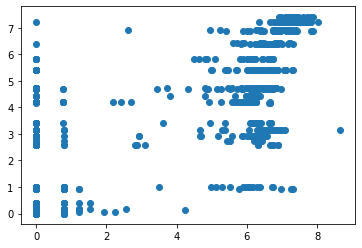

In [198]:
plt.scatter(y_test, pred)

In [196]:
from sklearn.model_selection import GridSearchCV
params = {'min_samples_split':np.arange(50,1000,50)}#, 'min_samples_leaf':[1,3, 5,8,10]}

dtr = DecisionTreeRegressor()
gscv = GridSearchCV(dtr, params, cv=5, verbose=0)

gscv.fit(X, y)

gscv.best_params_

C:\Users\Roberto\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 300}

In [200]:
res.iloc[res_sort.index[0]]

use       Technology/science
meter                      3
n_data                  8748
R2                  0.544843
mse                   4.5455
Name: 46, dtype: object

In [202]:
dtr

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=300, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [203]:
# put tuned tree into dtrs
dtrs[res_sort.index[0]] = dtr
dtrs[res_sort.index[0]]

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=300, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [97]:
sub_worst_data.groupby('building_id')['meter_reading'].count().to_frame()

,meter_reading
building_id,
177,8780
200,8780
232,8781
236,8781
249,8780
254,8782
284,8782
1021,8773
1270,8777


In [75]:
sub_worst_data.shape

(8772, 22)

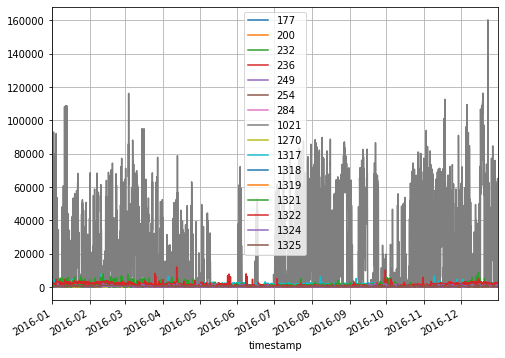

In [103]:
fig, ax = plt.subplots(figsize=(8,6))
for key, d in sub_worst_data.groupby('building_id'):
    d.plot(x='timestamp',y='meter_reading',ax=ax,label=key)

plt.grid();

In [79]:
building_per_category = tbw.groupby(['primary_use','meter'])['building_id'].nunique().to_frame()

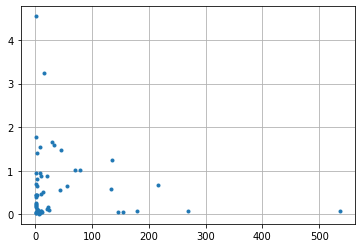

In [80]:
plt.plot(building_per_category.building_id, res.mse,marker='.',linewidth=0)
plt.grid();

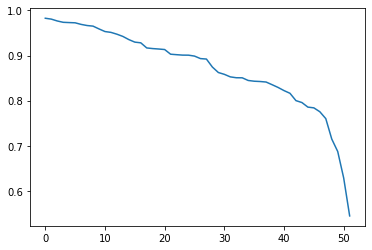

In [49]:
plt.plot(res.R2.sort_values(ascending=False).values)

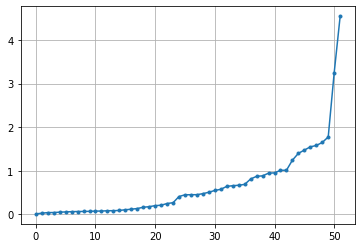

In [100]:
plt.plot(res.mse.sort_values().values,marker='.')
plt.grid()

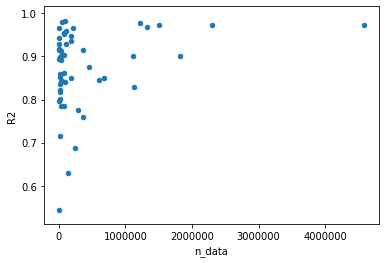

In [50]:
res.plot(x='n_data',y='R2',kind='scatter')

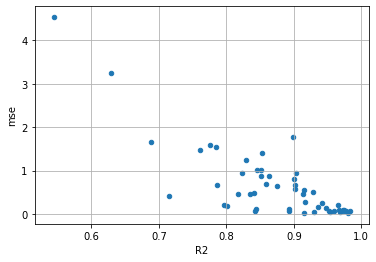

In [53]:
res.plot(x='R2',y='mse',kind='scatter')
plt.grid();

In [369]:
type(pred)

numpy.ndarray

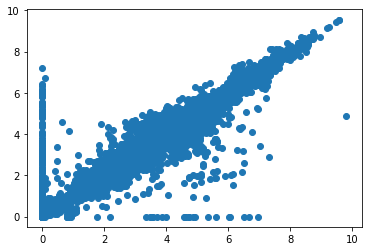

In [401]:
import random
ixx = np.random.randint(1, 1e6, size=(50000,1))
plt.scatter(y_test_values[ixx], pred[ixx]);

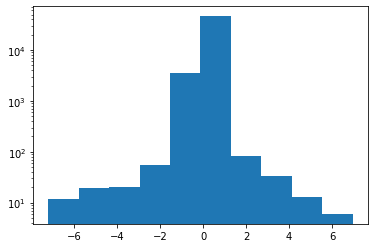

In [403]:
plt.hist(y_test_values[ixx]- pred[ixx]);
plt.yscale('log');

In [67]:
from xgboost import plot_tree

#plot_tree(dtrs[0], max_depth=3)

In [114]:
len(res_sort)

52

In [163]:
k=0

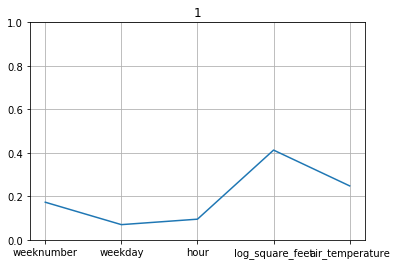

In [164]:
ixx = res_sort.index
k=k+1
fig, ax = plt.subplots()
ax.plot(dtrs[ixx[k]].feature_importances_)
ax.set_xticks(range(len(features_list)))
ax.set_xticklabels(features_list);
plt.ylim(0,1);
plt.title(str(k));

plt.grid();

In [165]:
res_sort.iloc[k]

use       Entertainment/public assembly
meter                                 3
n_data                           138796
R2                             0.628846
mse                             3.24964
Name: 7, dtype: object

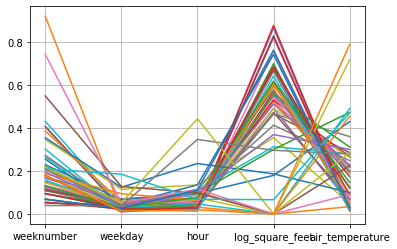

In [60]:
fig, ax = plt.subplots()
for dtr in dtrs:
    ax.plot(dtr.feature_importances_)
ax.set_xticks(range(len(features_list)))
ax.set_xticklabels(features_list);
plt.grid();

In [66]:
xx=dtrs[0].feature_importances_


0.6977077840930719

# grid search on tree

In [254]:
params = {'min_samples_split':[2,3,5], 'min_samples_leaf':[1,3, 5]}

from sklearn.model_selection import GridSearchCV
gscv = GridSearchCV( dtr, params, cv=3, verbose=3)

t0 = time()
gscv.fit(X_train, y_train)
print('Grid Search CV in {:.1f}s'.format(time()-t0) )

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] min_samples_leaf=1, min_samples_split=2 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_leaf=1, min_samples_split=2, score=0.967, total=  14.9s
[CV] min_samples_leaf=1, min_samples_split=2 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, score=0.968, total=  14.8s
[CV] min_samples_leaf=1, min_samples_split=2 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.8s remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, score=0.968, total=  15.1s
[CV] min_samples_leaf=1, min_samples_split=3 .........................
[CV]  min_samples_leaf=1, min_samples_split=3, score=0.968, total=  14.4s
[CV] min_samples_leaf=1, min_samples_split=3 .........................
[CV]  min_samples_leaf=1, min_samples_split=3, score=0.969, total=  14.3s
[CV] min_samples_leaf=1, min_samples_split=3 .........................
[CV]  min_samples_leaf=1, min_samples_split=3, score=0.969, total=  14.9s
[CV] min_samples_leaf=1, min_samples_split=5 .........................
[CV]  min_samples_leaf=1, min_samples_split=5, score=0.970, total=  13.4s
[CV] min_samples_leaf=1, min_samples_split=5 .........................
[CV]  min_samples_leaf=1, min_samples_split=5, score=0.971, total=  13.4s
[CV] min_samples_leaf=1, min_samples_split=5 .........................
[CV]  min_samples_leaf=1, min_samples_split=5, score=0.971, total=  13.6s
[CV] min_samples_leaf=3, min_samples_split=2 ...........

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.1min finished


Grid Search CV in 383.5s


In [257]:
gscv.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 2}

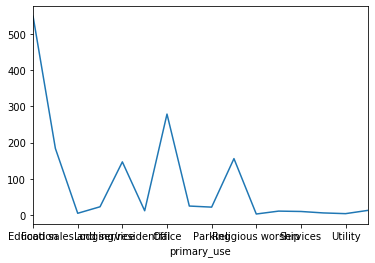

In [34]:
building_df.groupby('primary_use')['primary_use'].count().plot()

In [5]:
train_df.shape

(20216100, 4)

In [36]:
buildmax = train_df.iloc[train_df['meter_reading'].idxmax()]
print(buildmax)

building_id                     1099
meter                              2
timestamp        2016-06-13 09:00:00
meter_reading            2.19047e+07
Name: 8907488, dtype: object


In [38]:
train_m2 = train_df[train_df['meter']==2]
train_m2.shape

(2708713, 4)

In [75]:
train_m2_exp.loc[train_m2_exp['meter_reading'].idxmax()]

meter_reading    3.81388e+06
site_id                   13
building_id             1099
primary_use        Education
square_feet           332884
year_built               NaN
floor_count              NaN
Name: 1099, dtype: object

In [34]:
building_df[building_df['building_id']== buildmax]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


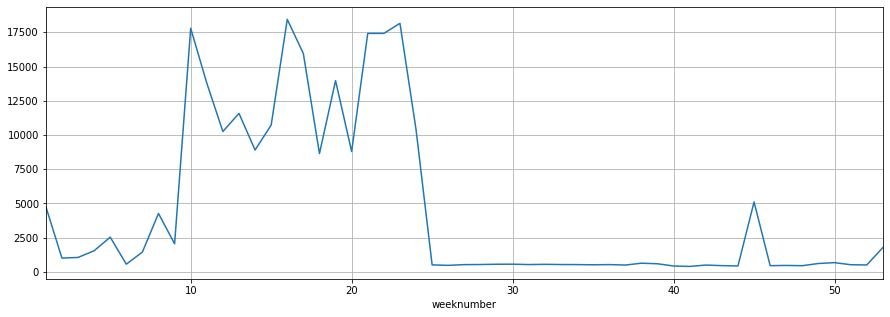

In [57]:
trainbuilding_edu_df.groupby('weeknumber')['meter_reading'].mean().plot(figsize=(15,5));
plt.grid()

Text(0, 0.5, 'datapoints')

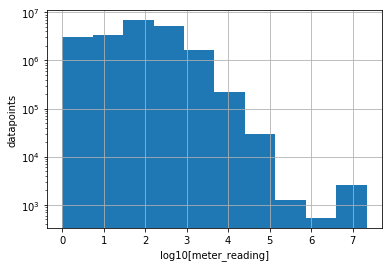

In [82]:
plt.hist(np.log10(1+train_df['meter_reading']))
plt.yscale('log');
plt.grid();
plt.xlabel('log10[meter_reading]')
plt.ylabel('datapoints');

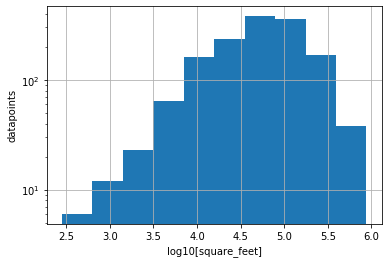

In [83]:
plt.hist(np.log10(1+building_df['square_feet']))
plt.yscale('log');
plt.grid();
plt.xlabel('log10[square_feet]')
plt.ylabel('datapoints');

# Prediction

In [213]:
test_df = read_file('test.csv')

test.csv read in 19.2 s
Mem. usage decreased to 596.49 Mb (53.1% reduction)


In [214]:
# convert into timestamp object
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'],format='%Y-%m-%d %H:%M:%S')
# split timestamp
test_df = split_timestamp(test_df)

In [215]:
test_df.head()

,row_id,building_id,meter,timestamp,hour,day,year,weeknumber,weekday,month
0,0,0,0,2017-01-01,0,1,2017,52,6,1
1,1,1,0,2017-01-01,0,1,2017,52,6,1
2,2,2,0,2017-01-01,0,1,2017,52,6,1
3,3,3,0,2017-01-01,0,1,2017,52,6,1
4,4,4,0,2017-01-01,0,1,2017,52,6,1


In [216]:
weather_test = read_file('weather_test.csv')

weather_test.csv read in 1.1 s
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [217]:
test_bw = pd.merge(test_df, building_df, how='left', left_on='building_id',right_on='building_id')
test_bw.head()

,row_id,building_id,meter,timestamp,hour,day,year,weeknumber,weekday,month,site_id,primary_use,square_feet,year_built,floor_count,log_square_feet
0,0,0,0,2017-01-01,0,1,2017,52,6,1,0,Education,7432,2008.0,NaN,8.913550
1,1,1,0,2017-01-01,0,1,2017,52,6,1,0,Education,2720,2004.0,NaN,7.908387
2,2,2,0,2017-01-01,0,1,2017,52,6,1,0,Education,5376,1991.0,NaN,8.589700
3,3,3,0,2017-01-01,0,1,2017,52,6,1,0,Education,23685,2002.0,NaN,10.072597
4,4,4,0,2017-01-01,0,1,2017,52,6,1,0,Education,116607,1975.0,NaN,11.666565
